In [33]:
import os
import numpy as np
import pandas as pd
import torch
import csv
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [35]:
input_path = "/kaggle/input/srl-dataset/"
project_path = "/kaggle/working/"

In [36]:
sentences = []
srl_tags = []
csv_file = input_path + "output_dataset.csv"
with open(csv_file, 'r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        sentence, srl = row
        words = sentence.split()
        srl_list = srl.split()
        sentences.append(words)
        srl_tags.append(srl_list)

In [5]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/wiki.hi.bin

--2024-05-08 21:52:50--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/wiki.hi.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.166.75, 13.35.166.43, 13.35.166.125, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.166.75|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-05-08 21:52:51 ERROR 403: Forbidden.



In [37]:
!pip install fasttext
import fasttext
import fasttext.util

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [38]:
fasttext.util.download_model('hi', if_exists='ignore')  # hi

'cc.hi.300.bin'

In [39]:
ft = fasttext.load_model('cc.hi.300.bin')

In [40]:
print(len(sentences[0]))
print(len(srl_tags[0]))

18
18


In [41]:
def GetFTEmbeddings(sentence):
    embed = []
    for i, w in enumerate(sentence):
        embed.append(ft.get_word_vector(w))
    return torch.tensor(embed)

In [42]:
print(len(sentences[0]))
print(len(GetFTEmbeddings(sentences[0])))
# print(ft.get_word_vector(sentences[0][1]))
tmp = torch.tensor(GetFTEmbeddings(sentences[0]))
print(tmp.shape)
print(tmp)

18
18
torch.Size([18, 300])
tensor([[-0.0328, -0.0100,  0.0359,  ...,  0.0052,  0.0536,  0.0243],
        [-0.0159,  0.0893,  0.0970,  ...,  0.0294,  0.0963,  0.0223],
        [ 0.1644, -0.2193,  0.1713,  ..., -0.1537,  0.0747,  0.0110],
        ...,
        [-0.0158, -0.0204,  0.0031,  ..., -0.0078,  0.0752, -0.0231],
        [-0.0084,  0.0049,  0.0380,  ..., -0.0005,  0.0400, -0.0468],
        [-0.0576,  0.0033,  0.0193,  ..., -0.0050, -0.0436,  0.0253]])


/tmp/ipykernel_33/3479519702.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tmp = torch.tensor(GetFTEmbeddings(sentences[0]))


In [ ]:
print(srl_tags)

[['ARGM-TMP', 'NO_SRL', 'ARG2-ATR', 'ARG1', 'NO_SRL', 'NO_SRL', 'ARGM-DIS', 'ARGM-LOC', 'ARG1', 'ARG2-ATR', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARG1', 'ARGM-MNR', 'ARG2-ATR', 'NO_SRL'], ['ARGM-TMP', 'ARG0', 'NO_SRL', 'ARG1', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARG0', 'NO_SRL', 'ARG1', 'NO_SRL'], ['NO_SRL', 'ARGM-LOC', 'NO_SRL', 'ARG1', 'NO_SRL'], ['ARG1', 'ARGM-MNR', 'NO_SRL', 'ARG2-ATR', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARG1', 'NO_SRL', 'NO_SRL', 'ARG0', 'NO_SRL', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARGM-MNR', 'NO_SRL', 'NO_SRL', 'ARG1', 'ARGM-TMP', 'NO_SRL', 'NO_SRL', 'ARGM-CAU', 'ARG1', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'ARG1', 'ARG2-ATR', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARG0', 'NO_SRL', 'ARG1', 'NO_SRL', 'ARG1', 'ARG2-ATR', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARG1', 'NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARG2-ATR', 'NO_SRL'], ['NO_SR

In [ ]:
# labels = ["ARG0","ARG1","ARG2","ARG3","ARG2-ATR","ARG2-LOC","ARG2-GOL","ARG2-SOU","ARGM-PRX","ARGM-ADV",
#         "ARGM-DIR","ARGM-EXT","ARGM-MNR","ARGM-PRP","ARGM-DIS","ARGM-LOC","ARGM-MNS","ARGM-NEG","ARGM-TMP",
#           "ARGM-CAU", "NO_SRL"]
A = set()
for arr in srl_tags:
    for tag in arr:
        A.add(tag)
labels = list(A)
label_dict = {label: index for index, label in enumerate(labels)}

In [ ]:
print(srl_tags[0][2])
print(sentences[0][2])
print(label_dict['NO_SRL'])
print(label_dict)

ARG2-ATR
मन
21
{'ARGM-PRX': 0, 'ARGM-MNS': 1, 'ARGM-DIR': 2, 'ARGM-NEG': 3, 'ARGM-DIS': 4, 'ARG0': 5, 'ARG2': 6, 'ARGM-MNR': 7, 'ARGM-EXT': 8, 'ARG2-ATR': 9, 'ARGM-ADV': 10, 'ARG3': 11, 'ARG2-SOU': 12, 'ARG-UNDEF': 13, 'ARGM-LOC': 14, 'ARGM-PRP': 15, 'ARG2-GOL': 16, 'ARGM-TMP': 17, 'ARG1': 18, 'ARGM-MOD': 19, 'ARGM-CAU': 20, 'NO_SRL': 21, 'ARG2-LOC': 22}


In [ ]:
# sentence_indices = []
label_indices = []
max_enc = 0
for i, sent in enumerate(sentences):
    # s_t = [2]
    # srl = [label_dict['NO_SRL']]
    srl = []
    for j, w in enumerate(sent):
        # w_t = tokenizer.encode(w, add_special_tokens=False)
        # max_enc = max(max_enc, len(w_t))
        # s_t.extend(w_t)
        srl.extend([label_dict[srl_tags[i][j]]])
    label_indices.append(srl)
    # sentence_indices.append(s_t)

In [ ]:
Xtrain = sentences[:-300]
Ytrain = label_indices[:-300]

Xtest = sentences[-300:]
Ytest = label_indices[-300:]

In [ ]:
print(len(Ytrain[0]))

18


In [ ]:
print(type(Xtrain))

<class 'list'>


---
---

<br>


In [ ]:
class SRLClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SRLClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out.contiguous().view(-1, self.hidden_dim))
        return out

In [ ]:
input_dim = 300
hidden_dim = 32
output_dim = len(label_dict)
srl_classifier = SRLClassifier(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(srl_classifier.parameters(), lr = 0.001)

In [ ]:
# batch_size = 32
# train_dataset = [(getEmbedding(sent), label) for sent, label in zip(Xtrain[:100], Ytrain[:100])]
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def trainClassifier(classifier, Xtrain, Ytrain, n_epochs, optimizer):
    losses = []
    for epoch in range(n_epochs):
        classifier.train()
        running_loss = 0.0
        with tqdm(total=len(Xtrain), desc=f"Epoch {epoch+1}/{n_epochs}") as pbar:
            i = 0
            for sent, labels in zip(Xtrain, Ytrain):
                optimizer.zero_grad()
                # encoded_sent = getEmbedding(sent, mask = train_masks[i])
                encoded_sent = GetFTEmbeddings(sent)
                encoded_sent = encoded_sent.reshape(1, encoded_sent.size(0), encoded_sent.size(1))
                # print("x shape - ", encoded_sent.shape)
                encoded_sent = encoded_sent.to(device)
                targets = torch.tensor(labels).to(device)
                targets = targets.reshape(1, targets.size(0))
                # print("y shape - ", targets.shape)
                outputs = classifier(encoded_sent).to(device)
                reshaped_outputs = outputs.view(-1, outputs.size(-1))
                reshaped_targets = targets.view(-1)
                loss = criterion(reshaped_outputs, reshaped_targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.update(1)
                i += 1
        epoch_loss = running_loss / len(Xtrain)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}\n")
    return losses

In [54]:
losses = trainClassifier(srl_classifier, Xtrain, Ytrain, 10, optimizer)

Epoch 1/10: 100%|██████████| 1007/1007 [00:03<00:00, 266.70it/s]


Epoch 1, Loss: 1.5668673226175147



Epoch 2/10: 100%|██████████| 1007/1007 [00:03<00:00, 267.57it/s]


Epoch 2, Loss: 1.3287398026444115



Epoch 3/10: 100%|██████████| 1007/1007 [00:04<00:00, 242.19it/s]


Epoch 3, Loss: 1.17129053153253



Epoch 4/10: 100%|██████████| 1007/1007 [00:03<00:00, 263.96it/s]


Epoch 4, Loss: 1.065969544998347



Epoch 5/10: 100%|██████████| 1007/1007 [00:04<00:00, 246.45it/s]


Epoch 5, Loss: 0.994275952137215



Epoch 6/10: 100%|██████████| 1007/1007 [00:03<00:00, 258.44it/s]


Epoch 6, Loss: 0.9389789720706812



Epoch 7/10: 100%|██████████| 1007/1007 [00:03<00:00, 271.77it/s]


Epoch 7, Loss: 0.8919939002264458



Epoch 8/10: 100%|██████████| 1007/1007 [00:03<00:00, 274.13it/s]


Epoch 8, Loss: 0.8497572493884628



Epoch 9/10: 100%|██████████| 1007/1007 [00:03<00:00, 275.37it/s]


Epoch 9, Loss: 0.810807039019723



Epoch 10/10: 100%|██████████| 1007/1007 [00:03<00:00, 267.43it/s]

Epoch 10, Loss: 0.7744466463305507



In [55]:
print(losses)

[1.5668673226175147, 1.3287398026444115, 1.17129053153253, 1.065969544998347, 0.994275952137215, 0.9389789720706812, 0.8919939002264458, 0.8497572493884628, 0.810807039019723, 0.7744466463305507]


In [56]:
print(Xtrain)
print(Ytrain)

[['सदियों', 'मानव', 'मन', 'सवाल', 'रहा', 'कि', 'क्या', 'अंतरिक्ष', 'हम', 'अकेले', 'हैं', 'या', 'ब्रह्मांड', 'ग्रह', 'जीवन', 'स्वरूप', 'मौजूद', 'है2'], ['अभी', 'वैज्ञानिकों', 'सवाल', 'जवाब', 'मिला', 'लेकिन', 'ग्रहों', 'खोज', 'वैज्ञानिकों2', 'उम्मीदें', 'बढ़ा'], ['पृथ्वी', 'ग्रहों', 'जीवन', 'उम्मीद', 'है'], ['ग्रह', 'पृथ्वी', 'ज्यादा', 'बड़े', 'हैं'], ['विज्ञानियों', 'हमारे', 'मंडल', 'अंतरिक्ष2', 'सूर्य', 'कैंसरी', 'तारे', 'NULL', 'परिक्रमा', 'करने', 'ग्रहों', 'वर्ग', 'पता', 'लगाया'], ['वाशिंगटन', 'बटलर', 'हमारे', 'पृथ्वी', 'ग्रह', 'अस्तित्व', 'जानकारी', 'फिलहाल', 'है', 'लेकिन', 'खोज', 'उम्मीद', 'जाग', 'कि', 'अंतरिक्ष', 'पृथ्वी2', 'ग्रह2', 'मौजूद', 'हो'], ['NULL', 'खोजे', 'ग्रह', 'पृथ्वी', 'हैं'], ['नासा', 'मुख्यालय', 'आयोजित', 'सम्मेलन', 'विज्ञानियों', 'बताया', 'कि', 'ग्रहों', 'द्रव्यमान', 'वरुण', 'नेपचून', 'के2', 'होगा', 'और', 'व्यास', 'हमारी', 'पृथ्वी', 'तुलना', 'ज्यादा', 'होगा2'], ['हालांकि', 'ग्रह', 'दशक', 'हमारे', 'NULL', 'सौरमंडल', 'NULL2', 'खोजे', 'ग्रहों', 'हैं'], ['ग्रहों', 'द्र्

In [57]:
def saveModel(model, path):
    torch.save(model.state_dict(), path)

def loadModel(model, path):
    if device == 'cuda':
        model.load_state_dict(torch.load(path))
    else:
        model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [58]:
saveModel(srl_classifier, project_path + "classifier3.pt")

In [59]:
# out = srl_classifier(xt.unsqueeze(0))

In [60]:
def evaluate(classifier, Xtest, Ytest):
    classifier.eval()
    total_samples = 0
    correct_samples = 0
    with torch.no_grad():
        for i, (sent, true_labels) in enumerate(zip(Xtest, Ytest)):
            encoded_sent = GetFTEmbeddings(sent)
            inputs = encoded_sent.unsqueeze(0).to(device)
            targets = torch.tensor(true_labels).to(device)
            outputs = classifier(inputs).to(device)
            predicted_labels = outputs.max(dim=1)[1].view(-1)
            total_samples += len(true_labels)
            # print("predicted - ", predicted_labels)
            # print("true - ", true_labels)
            correct_samples += (predicted_labels == targets).sum().item()
            # break
    test_accuracy = correct_samples / total_samples
    return test_accuracy

In [61]:
a1 = evaluate(srl_classifier, Xtest, Ytest)

In [62]:
print(a1)

0.6951292844257366


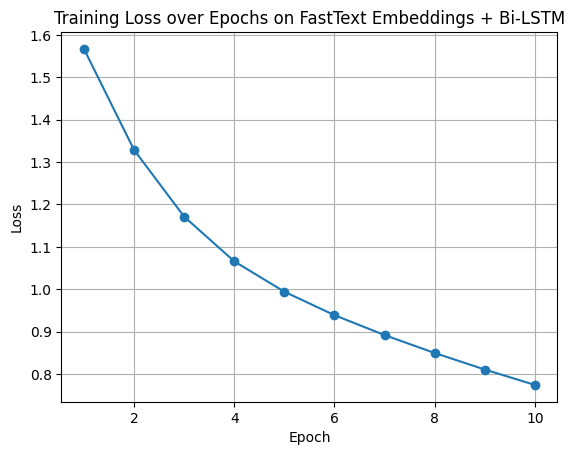

In [63]:
import matplotlib.pyplot as plt
# Plot the losses
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
plt.title('Training Loss over Epochs on FastText Embeddings + Bi-LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [64]:
y_test_pred_total = []
y_test_true_total = []

In [70]:
def evaluate(classifier, Xtest, Ytest):
    classifier.eval()
    total_samples = 0
    correct_samples = 0
    with torch.no_grad():
        for i, (sent, true_labels) in enumerate(zip(Xtest, Ytest)):
            encoded_sent = GetFTEmbeddings(sent)
            inputs = encoded_sent.unsqueeze(0).to(device)
            # print("input shape -", inputs.shape)
            # print("rel shape -", rel.shape)
            targets = torch.tensor(true_labels).to(device)
            outputs = classifier(inputs).to(device)
            predicted_labels = outputs.max(dim=1)[1].view(-1)
            total_samples += len(true_labels)
            # print("predicted - ", predicted_labels)
            # print("true - ", true_labels)
            correct_samples += (predicted_labels == targets).sum().item()
            y_test_pred_total.extend(predicted_labels.cpu().numpy())
            y_test_true_total.extend(targets.cpu().numpy())
            # break
    test_accuracy = correct_samples / total_samples
    return test_accuracy

In [71]:
a1 = evaluate(srl_classifier, Xtest, Ytest)

In [72]:
print(y_test_pred_total[0])
print(y_test_true_total[0])

14
14


In [73]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_true_total, y_test_pred_total))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.27      0.12      0.17        24
           5       0.60      0.48      0.53       227
           6       0.00      0.00      0.00        32
           7       0.50      0.16      0.24        74
           8       0.00      0.00      0.00        23
           9       0.42      0.46      0.44        84
          10       0.00      0.00      0.00        23
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00        11
          14       0.29      0.22      0.25       163
          15       0.00      0.00      0.00        22
          16       0.00      0.00      0.00        18
          17       0.38      0.29      0.33        79
          18       0.51      0.60      0.55       415
          19       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# print(a1)